# 👔 Master Class: E-Commerce Clothing Classification with EfficientNet-B3
### Author: Göktan İren

## Topic: Computer Vision, Transfer Learning, Fine-Tuning

Framework: PyTorch

## 📖 Introduction
In the world of E-Commerce, automated tagging and categorization are crucial for user experience. In this notebook, we push the boundaries of accuracy on the Men's Clothing Dataset. We aren't just training a model; we are engineering a robust pipeline using State-of-the-Art (SOTA) techniques.

### Key Techniques We Will Use:

- EfficientNet-B3: A powerful, scalable CNN architecture.

- Transfer Learning: Leveraging ImageNet weights.

- RandAugment: Google's automated data augmentation strategy.

- Label Smoothing: To prevent the model from becoming over-confident and overfitting.

- Cosine Annealing: A dynamic learning rate scheduler for better convergence.

- Mixed Precision (AMP): To speed up training and reduce memory usage on the GPU.

## 1. Setup and Configuration
First, let's import the necessary libraries and define our hyperparameters. We are using EfficientNet-B3, which offers a great balance between accuracy and computational efficiency compared to the B0 baseline.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import copy

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# HYPERPARAMETERS
model_name = "efficientnet_b3"
IMG_SIZE = 300       # Optimal input size for B3
BATCH_SIZE = 16      # Reduced batch size for larger model/image
LR_INIT = 1e-3       # Initial learning rate for the classifier head
LR_FINE = 1e-4       # Lower learning rate for fine-tuning
WEIGHT_DECAY = 1e-4  # Regularization
EPOCHS_HEAD = 4      # Warmup epochs
EPOCHS_FINE = 12     # Fine-tuning epochs

# Data Path
DATA_DIR = '/kaggle/input/e-commerce-mens-clothing-dataset/dataset_clean'

Device: cuda


## 2. Advanced Data Augmentation
To prevent overfitting, we use RandAugment. Unlike standard augmentation (which applies fixed operations), RandAugment learns the best sequence of transformations (rotation, shear, contrast, etc.) to make the model robust.

In [2]:
# Strong Augmentation for Training
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandAugment(num_ops=2, magnitude=9), # Google's auto-augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Standard Normalization for Validation
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 3. Data Loading and Dynamic Splitting
Since the dataset is folder-based but not split into Train/Val, we handle this dynamically in memory. Crucial Step: We create a custom TransformedDataset wrapper. This ensures that the heavy augmentations are only applied to the training set, while the validation set remains clean.

In [3]:
full_dataset = datasets.ImageFolder(root=DATA_DIR)
class_names = full_dataset.classes

# 85% Train, 15% Validation split
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_data, val_data = random_split(
    full_dataset, 
    [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Wrapper to apply specific transforms to splits
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_data, transform=train_transforms)
val_dataset = TransformedDataset(val_data, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Classes: {class_names}")

Training Samples: 7331
Validation Samples: 1294
Classes: ['casual_shirts', 'formal_pants', 'formal_shirts', 'jeans', 'men_cargos', 'printed_hoodies', 'printed_tshirts', 'solid_tshirts']


## 4. Model Architecture & Label Smoothing
We load the pre-trained EfficientNet-B3.

Custom Head: We replace the top layer with a custom classifier including Dropout (to reduce overfitting).

Label Smoothing: Instead of forcing the model to predict 100% confidence (1.0), we soften the target (e.g., 0.9). This helps the model generalize better on unseen data.

In [4]:
# Load Pretrained EfficientNet-B3
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

# Modify the Classifier Head
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.3), # Dropout helps reduce overfitting
    nn.Linear(num_ftrs, len(class_names))
)

model = model.to(device)

# Loss Function with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: AdamW (Standard Adam with fixed weight decay)
optimizer = optim.AdamW(model.parameters(), lr=LR_INIT, weight_decay=WEIGHT_DECAY)

# Scheduler: Cosine Annealing Warm Restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 166MB/s]


## 5. The Training Engine (with Mixed Precision)
This function handles the training loop. We use AMP (Automatic Mixed Precision) to scale gradients. This allows us to train faster and use less VRAM without losing accuracy.

In [5]:
from torch.cuda.amp import autocast, GradScaler
import time

scaler = GradScaler() # For Mixed Precision

def train_advanced(model, epochs, optimizer, scheduler, is_fine_tuning=False):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Freeze layers if not fine-tuning, Unfreeze if fine-tuning
    if not is_fine_tuning:
        print("\n--- PHASE 1: Head Training (Feature Extractor Frozen) ---")
        for param in model.features.parameters():
            param.requires_grad = False
    else:
        print("\n--- PHASE 2: Fine-Tuning (Full Model Unfrozen) ---")
        for param in model.parameters():
            param.requires_grad = True
            
    for epoch in range(epochs):
        start_time = time.time()
        
        # --- TRAINING ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed Precision Forward
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        if is_fine_tuning: 
            scheduler.step()
            
        train_loss = running_loss / total
        train_acc = correct / total
        
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.0f}s | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        # Log History
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history

/tmp/ipykernel_24/2359045818.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # For Mixed Precision


## 6. Phase 1: Head Training (Warmup)
In this phase, we freeze the "body" of the EfficientNet and only train our new custom classifier layer. This prevents the random weights of the new layer from destroying the pre-trained ImageNet patterns in the body.

In [6]:
# Train only the classifier head
model, hist1 = train_advanced(model, EPOCHS_HEAD, optimizer, scheduler, is_fine_tuning=False)


--- PHASE 1: Head Training (Feature Extractor Frozen) ---


/tmp/ipykernel_24/2359045818.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4 | Time: 68s | Train Loss: 1.2994 Acc: 0.6429 | Val Loss: 0.9574 Acc: 0.8230
Epoch 2/4 | Time: 43s | Train Loss: 1.0726 Acc: 0.7276 | Val Loss: 0.8925 Acc: 0.8292
Epoch 3/4 | Time: 43s | Train Loss: 1.0319 Acc: 0.7504 | Val Loss: 1.1702 Acc: 0.8416
Epoch 4/4 | Time: 42s | Train Loss: 1.0372 Acc: 0.7491 | Val Loss: 0.8541 Acc: 0.8532


## 7. Phase 2: Fine-Tuning (The Magic)
Now, we unfreeze the entire model. We lower the learning rate significantly (1e-4) to gently adjust the pre-trained weights to our specific dataset without losing the general features learned from ImageNet.

In [7]:
# Re-initialize optimizer with lower learning rate for fine-tuning
optimizer_ft = optim.AdamW(model.parameters(), lr=LR_FINE, weight_decay=WEIGHT_DECAY)
scheduler_ft = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5)

# Train the full model
model, hist2 = train_advanced(model, EPOCHS_FINE, optimizer_ft, scheduler_ft, is_fine_tuning=True)


--- PHASE 2: Fine-Tuning (Full Model Unfrozen) ---


/tmp/ipykernel_24/2359045818.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/12 | Time: 95s | Train Loss: 0.8558 Acc: 0.8429 | Val Loss: 0.6680 Acc: 0.9304
Epoch 2/12 | Time: 83s | Train Loss: 0.7060 Acc: 0.9074 | Val Loss: 0.6373 Acc: 0.9328
Epoch 3/12 | Time: 83s | Train Loss: 0.6479 Acc: 0.9370 | Val Loss: 0.6091 Acc: 0.9474
Epoch 4/12 | Time: 83s | Train Loss: 0.6176 Acc: 0.9501 | Val Loss: 0.6076 Acc: 0.9436
Epoch 5/12 | Time: 82s | Train Loss: 0.6015 Acc: 0.9592 | Val Loss: 0.6029 Acc: 0.9474
Epoch 6/12 | Time: 83s | Train Loss: 0.6104 Acc: 0.9528 | Val Loss: 0.5961 Acc: 0.9420
Epoch 7/12 | Time: 83s | Train Loss: 0.5886 Acc: 0.9599 | Val Loss: 0.6079 Acc: 0.9389
Epoch 8/12 | Time: 83s | Train Loss: 0.5595 Acc: 0.9748 | Val Loss: 0.5944 Acc: 0.9436
Epoch 9/12 | Time: 83s | Train Loss: 0.5438 Acc: 0.9809 | Val Loss: 0.5956 Acc: 0.9482
Epoch 10/12 | Time: 83s | Train Loss: 0.5323 Acc: 0.9875 | Val Loss: 0.5909 Acc: 0.9474
Epoch 11/12 | Time: 83s | Train Loss: 0.5490 Acc: 0.9791 | Val Loss: 0.5956 Acc: 0.9474
Epoch 12/12 | Time: 83s | Train Loss: 0.5

## 8. Performance Analysis
Let's visualize the training trajectory and the final classification metrics. We look for the "elbow point" where validation loss stabilizes.

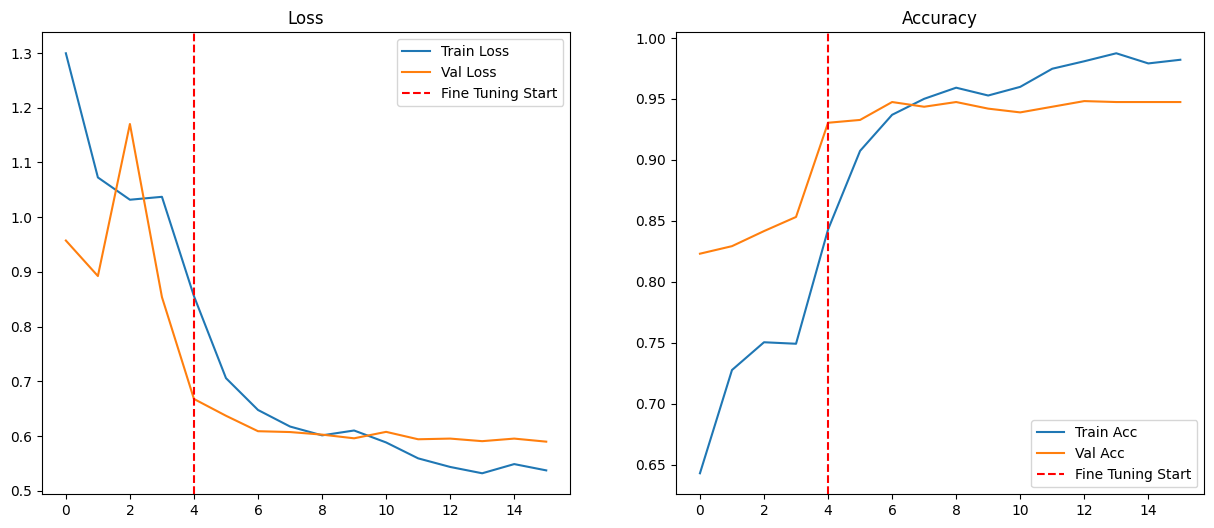


--- FINAL CLASSIFICATION REPORT ---
                 precision    recall  f1-score   support

  casual_shirts     0.9600    0.9385    0.9492       179
   formal_pants     0.9565    0.9925    0.9742       133
  formal_shirts     0.9448    0.9277    0.9362       166
          jeans     0.9756    0.9412    0.9581       170
     men_cargos     0.9524    0.9722    0.9622       144
printed_hoodies     0.9864    0.9932    0.9898       146
printed_tshirts     0.9075    0.9290    0.9181       169
  solid_tshirts     0.9144    0.9144    0.9144       187

       accuracy                         0.9482      1294
      macro avg     0.9497    0.9511    0.9503      1294
   weighted avg     0.9484    0.9482    0.9482      1294



In [8]:
# Merge histories from both phases
full_history = {
    'train_acc': hist1['train_acc'] + hist2['train_acc'],
    'val_acc': hist1['val_acc'] + hist2['val_acc'],
    'train_loss': hist1['train_loss'] + hist2['train_loss'],
    'val_loss': hist1['val_loss'] + hist2['val_loss']
}

# Plotting
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(full_history['train_loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.axvline(x=EPOCHS_HEAD, color='r', linestyle='--', label='Fine Tuning Start')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['train_acc'], label='Train Acc')
plt.plot(full_history['val_acc'], label='Val Acc')
plt.axvline(x=EPOCHS_HEAD, color='r', linestyle='--', label='Fine Tuning Start')
plt.title('Accuracy')
plt.legend()
plt.show()

# Classification Report
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

## 9. Visual Intelligence: What does the model see?
Numbers are good, but eyes are better. Here we visualize:

##### 1. Confidence Scores: How sure is the model?

##### 2. Confusion Matrix: Which specific classes are getting mixed up?

Predictions on Test Data:


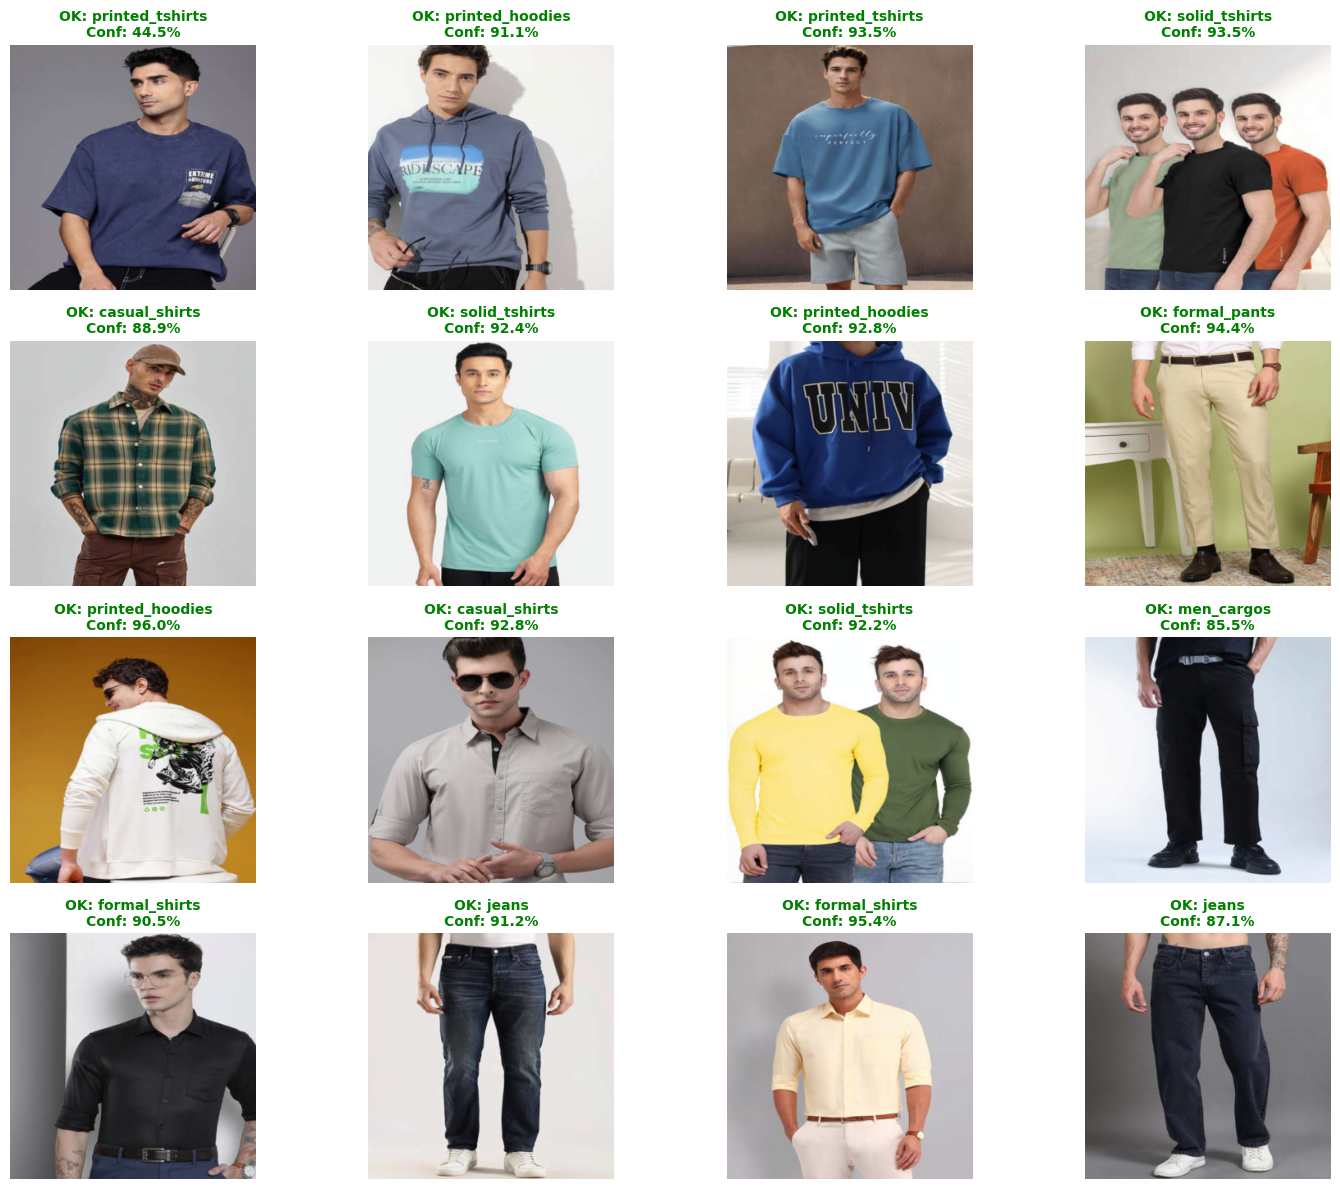


Detailed Error Analysis:


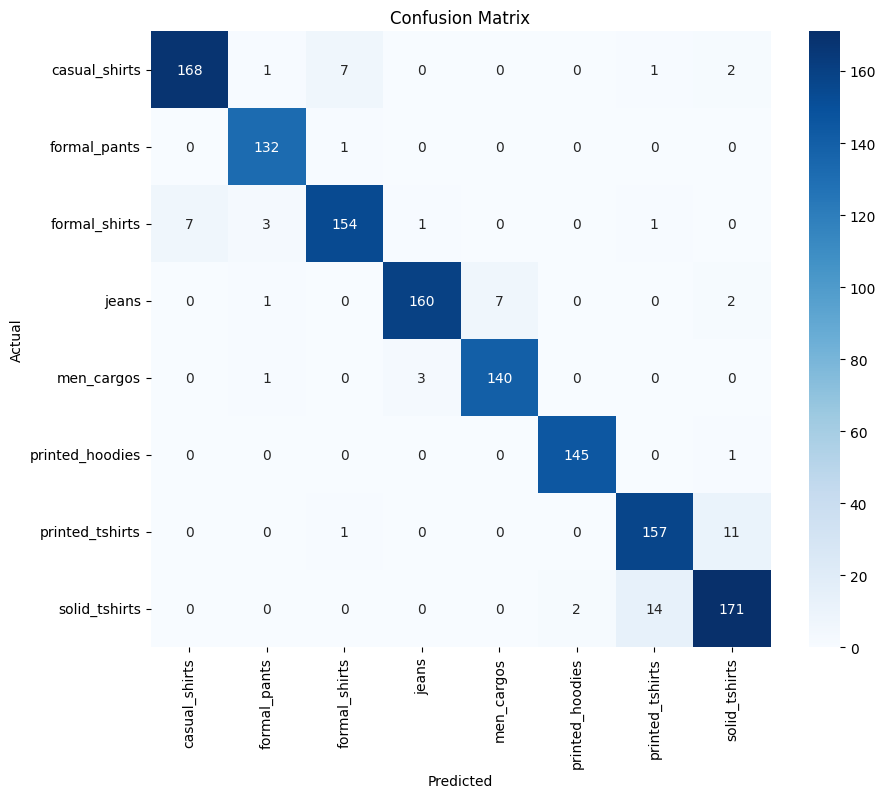

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Helper: Denormalize image for display
def imshow(inp, title=None, color='black'):
    inp = inp.numpy().transpose((1, 2, 0)) # (C, H, W) -> (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, color=color, fontsize=10, fontweight='bold')
    plt.axis('off')

# Visualize Predictions
def visualize_model_predictions(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 4, images_so_far)
                
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                probability = conf[j].item() * 100
                
                if true_label == pred_label:
                    color = 'green'
                    title = f"OK: {pred_label}\nConf: {probability:.1f}%"
                else:
                    color = 'red'
                    title = f"MISS!\nTrue: {true_label}\nPred: {pred_label} ({probability:.1f}%)"
                
                imshow(inputs.cpu().data[j], title, color)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

# Confusion Matrix
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# EXECUTE VISUALIZATION
print("Predictions on Test Data:")
visualize_model_predictions(model, num_images=16)

print("\nDetailed Error Analysis:")
plot_confusion_matrix(model, val_loader)